In [7]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import pennylane as qml
import scipy as sp
from autograd import grad, jacobian

# Pennylane numpy
from pennylane import numpy as pnp 

In [8]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.qubit', wires=2)
# dev = qml.device('default.mixed', wires=2)

# Define Hamiltonian for quantum computations
H = qml.Hamiltonian(coeffs=[-0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1)])

$$
H = -0.5 \cdot Z_0 - 0.5 \cdot Z_1 
$$

$$
= -0.5 \cdot (Z \otimes I) - 0.5 \cdot (I \otimes Z)
$$

$$

$$


$$
where,
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

In [9]:
# Global Parameters
Tau_global = 0
Paras_global = pnp.zeros(3)
Phi_global = 0
Gamma_ps = 0

# Data Index
class DataIndex(Enum):
    BEFORE = 0
    BEGIN = 1
    PHI = 0
    CFI = 1
    PARAS = 2
    THETA_X = 2
    TAU_1 = 3
    TAU_2 = 4

def Dephase_factor(tau):
    """ Take tau and return gamma based on the following relation."""
    
    return 1 - np.exp(-2 * tau)    # Return gamma

$$
Let, e^{-t/T_2} = e^{-\tau} \\[1em]

\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}
$$

$$
\\[1em]
Then,
\quad \gamma = 
1 - e^{-2 \tau}
$$

$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

In [16]:
DataIndex.PARAS.value

2

In [10]:
@qml.qnode(dev, interface='autograd')
def circuit(paras):
    
    # Call global phi
    global Phi_global, Tau_global
    phi = Phi_global
    
    # Assign paras
    theta_x = paras[0]
    tau_1 = paras[1]
    tau_2 = paras[2]

    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(H, tau_1, 1)
    
    qml.RX(theta_x, wires = 0)    
    qml.RX(theta_x, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(H, tau_2, 1)

    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(H, phi, 1)
    
    qml.RX(np.pi/(2), wires=0)
    qml.RX(np.pi/(2), wires=1)
    # qml.RY(-np.pi/(2+1e-6), wires=0)
    # qml.RY(-np.pi/(2+1e-6), wires=1)
    
    return qml.state()
    # return qml.density_matrix(wires = [0, 1])

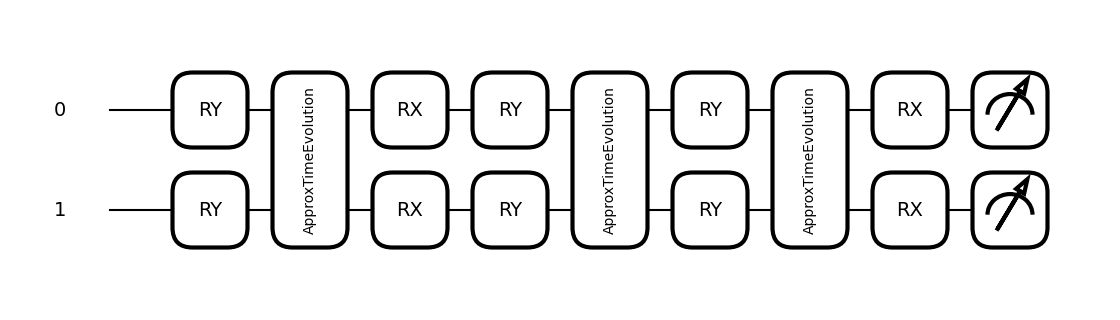

In [11]:
@qml.qnode(dev, interface = 'autograd')
def Post_selection_Dephase(phi):
    """ Take qnode from circuit_1 and calculate decoherence using kraus operator.
    
    Args:
        phi (float): Phi for Time-approximation. Pass by global variables:'Phi_global'

    Returns:
        qml.density_matrix: Density matrix of full qnode
    """
    
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires = [0, 1])
    
    # Kraus operator for 2*2 matrix
    K = np.array([
        [np.sqrt(1 - Gamma_ps), 0], 
        [0, 1]
    ])
    
    Numerator = np.kron(K, np.eye(2)) @ density_matrix @ np.kron(K, np.eye(2)).conj().T
    Denominator = np.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = [0, 1])
    
    return qml.density_matrix(wires = [0, 1])  

para_plot = pnp.array([1, 1, 1])
fig, ax = qml.draw_mpl(circuit)(para_plot)

In [12]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global = paras
    phi = pnp.array([Phi_global], requires_grad = True)
    
    CFI = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi[0])
    
    return -CFI

In [13]:
# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def run_optimization(sweep_data, initial_parameters, gamma_ps, iterations):
    """ 
    Main function to perform optimization over a range of phi values using the BFGS algorithm.
    
    Args:
        sweep_data (tuple): (start, end, step) values for the phi sweep.
        initial_parameters (numpy_array): Initial parameters for optimization.
        gamma_ps (int): Gamma value for post-selection.
        iterations (int): Number of iterations for the optimization.

    Returns:
        numpy.ndarray: A 3-D array containing phi, CFI, and optimized parameters after each iteration.
    """
    
    # Create Data array
    PHI = np.arange(sweep_data[0], sweep_data[1], sweep_data[2])
    Data = np.zeros((iterations + 1, len(PHI), len(initial_parameters) + DataIndex.PARAS.value)) 
    Data[:, :, DataIndex.PHI.value] = PHI.squeeze() # Append PHI in to 0th col
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global, Tau_global
    Gamma_ps = gamma_ps 
    
    # Declare Paras temp 
    paras_temporary = 0
    
    # Store initial CFI data and parameters
    for idx in range(len(PHI)):
        Data[DataIndex.BEFORE.value][idx][DataIndex.CFI.value] = -Cost_function(initial_parameters)
        Data[DataIndex.BEFORE.value][idx][DataIndex.PARAS.value:] = initial_parameters
        
    # Optimize begin
    for iteration in range(DataIndex.BEGIN.value, iterations + DataIndex.BEGIN.value):  # Number of index(begin) = 1 
        for phi_idx, phi_current in enumerate(PHI):
            # Determine initial parameters based on the iteration
            if iteration == 1:
                paras_temporary = initial_parameters
                
            else:
                paras_temporary = Data[iteration][phi_idx][DataIndex.PARAS.value:]
            
            # Update the global Phi value
            Phi_global = phi_current

            # Determine constraints
            constraints = get_constraints(phi_current, gamma_ps, Tau_global, len(initial_parameters))

            # Optimize the data
            N = int(phi_current / pnp.pi) * pnp.pi
            if Gamma_ps == 8e-1:
                if Tau_global == 0:
                    paras_temporary = pnp.array([pnp.pi/2, pnp.pi/2])

                elif (pnp.pi/2 + N <= phi_current <= 2.1 + N):   # Up next
                    paras_temporary = pnp.array([pnp.pi/2, 1])

            Paras_global = paras_temporary

            result_BFGS = BFGS(paras_temporary, constraints)
            Data[iteration][phi_idx][DataIndex.CFI.value] = -result_BFGS.fun
            Data[iteration][phi_idx][DataIndex.PARAS.value:] = result_BFGS.x
            
    return Data

def BFGS(initial_parameters, constraints):
    """
    Perform the BFGS optimization algorithm.

    Args:
        initial_parameters (numpy_array): The starting point for the optimization.
        constraints (list of tuple): Bounds on the variables for the optimization.

    Returns:
        OptimizeResult: The result of the optimization process.
    """
    # Load gradient & jacobian of cost-function
    gradient = grad(Cost_function)
    hessian = jacobian(gradient)

    optimization_result = sp.optimize.minimize(
                fun = Cost_function, 
                x0 = initial_parameters, 
                method = 'L-BFGS-B', 
                bounds = constraints,
                jac = gradient,
                hess = hessian,
                
                tol = 1e-12,
                options={
                    'ftol': 1e-12, 
                    'gtol': 1e-12
                }
            )
    
    return optimization_result

def get_constraints(phi_current, gamma_ps, tau_current, len_paras):
    """
    Calculate the constraints for the optimization based on current phi, gamma and tau values.

    Args:
        phi_current (float): The current value of phi in the optimization loop.
        gamma_ps (float): Gamma value for post-selection.
        tau_current (float): Current value of tau.

    Returns:
        list of tuple: Constraints for the optimization variables.
    """
    
    N = 2*np.pi * int(phi_current / (2*np.pi))
    
    return [(-float('inf'), float('inf'))] * len_paras        

NameError: name 'Data' is not defined